In [1]:
import os
import tarfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker
import time
import re
import io
from tqdm import tqdm    # tqdm
import random




print(tf.__version__)

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager.findfont(font)
# '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

2.6.0


'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
os.getcwd()

'/aiffel/aiffel/s2s_translation'

In [3]:
# train
data_path = "/aiffel/aiffel/s2s_translation/data"
file_name = "korean-english-park.train.tar.gz"
file_path = os.path.join(data_path, file_name)

if tarfile.is_tarfile(file_path):
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=data_path)
        print(f"압축 해제 : {file_name}")
else:
    print(f"'{file_name}'압축 해제 실패")

압축 해제 : korean-english-park.train.tar.gz


In [4]:
# test
data_path = "/aiffel/aiffel/s2s_translation/data"
file_name = "korean-english-park.test.tar.gz"
file_path = os.path.join(data_path, file_name)

if tarfile.is_tarfile(file_path):
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=data_path)
        print(f"압축 해제 : {file_name}")
else:
    print(f"'{file_name}'압축 해제 실패")

압축 해제 : korean-english-park.test.tar.gz


In [5]:
# korean-english-park.test.en
# korean-english-park.test.ko
# korean-english-park.train.en
# korean-english-park.train.ko
train_ko_path = os.path.join(data_path, "korean-english-park.train.ko")
train_en_path = os.path.join(data_path, "korean-english-park.train.en")
test_ko_path = os.path.join(data_path, "korean-english-park.test.ko")
test_en_path = os.path.join(data_path, "korean-english-park.test.en")

def load_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.readlines()
    return data

train_ko = load_file(train_ko_path)
train_en = load_file(train_en_path)
test_ko = load_file(test_ko_path)
test_en = load_file(test_en_path)

In [6]:
print("train_ko length :", len(train_ko))
print("train_en length:", len(train_en))
print("test_ko length:", len(test_ko))
print("test_en length:", len(test_en))

train_ko length : 94123
train_en length: 94123
test_ko length: 2000
test_en length: 2000


In [7]:
2000/(94123+2000)

0.02080667478126983

In [8]:
# 병렬쌍이 흐트러지지 않게 묶어버리기 
train_pairs = list(zip(train_ko, train_en))

# 병렬쌍 (한영 전부 같은 것들) 중복 제거
train_pairs = list(set(train_pairs))

# 다시 분리
train_ko, train_en = zip(*train_pairs)

# 리스트화 
train_ko = list(train_ko)
train_en = list(train_en)

print(f"train_ko length: {len(train_ko)}")
print(f"train_en length: {len(train_en)}")

train_ko length: 78968
train_en length: 78968


In [9]:
test_pairs = list(zip(test_ko, test_en))

test_pairs = list(set(test_pairs))

test_ko, test_en = zip(*test_pairs)

test_ko = list(test_ko)
test_en = list(test_en)

print(f"train_ko length: {len(test_ko)}")
print(f"train_en length: {len(test_en)}")

train_ko length: 1996
train_en length: 1996


### 전처리

In [10]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


* 한->영 번역기를 만들어야하는데 한국어 데이터셋에 
* 'Possibility of summit talks to consider 남북한 정상회담 시기 적절치 않아\xa0 \xa0 \xa02007.05\n'와 같은 영어문장이 있으면??
### 언어 필터링 라이브러리 사용

In [11]:
from langdetect import detect

# 언어 구별 함수 
def is_not_korean(text):
    try:
        return detect(text) != 'ko'
    except:
        # 언어 감지 실패 시 not kor로 
        return True

# 한국어가 아닌 문장만 
non_korean_sentences = [sentence for sentence in train_ko if is_not_korean(sentence)]

# 개수
print(f"한국어가 아닌 문장 수: {len(non_korean_sentences)}")

한국어가 아닌 문장 수: 3449


In [12]:
# 확실히 번역기에 들어가봐야 모델 성능만 떨어뜨릴 문장들이다.
non_korean_sentences

['1998년 그는 다우존스 뉴스와이어(Dow Jones Newswires)사장으로 지명됐다.\n',
 'curtail a speech,, one’s holiday (연설, 휴가를 줄이다)\n',
 '##http://article.joins.com/article/cnn_e/article.asp?cat_code=22&Total_ID=3108483 1.\n',
 'White House website changed as Obama becomes new president 오바마가 새 대통령이 됨에따라 백악관 홈페이지 개편\xa0 \xa0 \xa02009.01\n',
 'Israeli to widen ground offensive이스라엘, 지상군 공격 확대키로2006.09\n',
 'resign 사퇴하다\n',
 'domestic 가정의, 기정적인, 국내의, 하인\n',
 'toxic 유독성, 중독성\n',
 'save의 주체는 a Japanese business이고,\xa0목적어 it는 Locky Company를 받는다.\n',
 'Capitol Hill 미 국회의사당\n',
 'Australia wants Iraq troops home by mid 2008 호주, 이라크 파병 호주군 2008년까지 철군 희망\xa0 \xa0 \xa0200806.11\n',
 '온라인 최종 교섭에서 거짓을 찾아내기 (Being Honest Online:\n',
 'Korean scientists conducted secret nuclear fuel experiments.한국 과학자들, 비밀리에 핵 연료 실험2005.08\n',
 'Maginot Line 마지노선, 저지선\n',
 'President Roh slams Japan for its ‘pre-emptive strikes’ remark노대통령, 일본의 ‘대북선제공격론’ 비난2006.09\n',
 'Park Geun-hye quits party leadership post박근혜 한나라당 대표직 물러나2006.06\n',
 'it는

In [13]:
# 제거
print(f"필터링 전 kor 문장 수: {len(train_ko)}")
print(f"필터링 전 eng 문장 수: {len(train_en)}")
print("---------------------")
# 한-영 쌍으로 탈락시켜야 하기에 한국어가 아닌 문장을 찾는 인덱스가 필요함
non_korean_indices = [i for i, sentence in enumerate(train_ko) if sentence in non_korean_sentences]

# non_korean_indices 기준으로 train_ko와 train_en 전부 전처리 
train_ko = [sentence for i, sentence in enumerate(train_ko) if i not in non_korean_indices]
train_en = [sentence for i, sentence in enumerate(train_en) if i not in non_korean_indices]

# 결과 출력
print(f"필터링 후 kor 문장 수: {len(train_ko)}")
print(f"필터링 후 eng 문장 수: {len(train_en)}")

필터링 전 kor 문장 수: 78968
필터링 전 eng 문장 수: 78968
---------------------
필터링 후 kor 문장 수: 75508
필터링 후 eng 문장 수: 75508


In [14]:
train_ko

['치와와 애완견인 피피의 눈은 주인이 일하고 있는 비좁은 옷 가게에서 낯선 사람들이 접근하면 사납게 튀어나온다.\n',
 '매도프가 뉴욕에서 5050억달러 폰지 사기 혐의로 체포된 지 8일 뒤인 지난해 12월 19일 조각상을 도난 당했다.\n',
 '국방부 부장관으로서 2005년 2월부터 지난 6월까지 곤돌리자 라이스 장관을 보좌했다.\n',
 '한미무역협정 반대 연합의 회원인 민주노총과 농민총연합, 전국 노점상 연합의 회원 5천 여명이 민주노동당의 시위에 참가했다.\n',
 '캘리포니아 대법원은 오늘 샌프란시스코에서 주에서 투표를 통해 통과한 동성 결혼 철폐의 입헌성에 대한 의견을 듣게 됩니다.\n',
 '그러나 태평양 쓰나미 센터 관계자들은 새로운 쓰나미가 발생할 조짐을 보이지 않고 있다고 밝혔다.\n',
 '한국은 또한 해당 지역 내에 약 200명의 평화유지군을 주둔시키고 있는데, 연말까지 철군 계획이 이미 수립되어 있다.\n',
 '퍼듀대학(Purdue University) 연구원이 2001년 9월 11일 일어난 세계무역센터(WTC) 테러를 컴퓨터 모의 실험으로 제작, 유튜브(YouTube)에 올렸다.\n',
 '한편 미 국방성은 고장난 첩보 위성에 대해 아무런 조치를 취하지 않을 경우 위성이 3월 초 발사지점에 떨어질 것이라고 예상했다.\n',
 '이라크는 현재 세계 에서 1인당 사형집행률이 4번째로 높은 나라다.\n',
 '미어에 의하면 자마이카 정부의 헬리콥터는 DNA 샘플 처리가 끝나자 샘플을 다시 킹스턴으로 가져갔다고 했다.\n',
 '그러나 이는 미국과 유럽 제약 회사들에게는 기회의 문을 열어 준 격이었으며, 이들은 아주 헐값으로 수십 가지의 유망 의약품에 대한 권리를 확보했다.\n',
 '배가 아파 병원에 갔던 9살 여자아기의 위에서 쌍둥이 태아가 발견됐다고 그리스의 한 종합병원 의료진이 15일(현지시간) 밝혔다.\n',
 '코랄레스는 지난 2005년 5월 7일 카스티요를 10회 TKO로 제압했다.\n',
 '에드워즈는 “우리가 같은 목적

In [16]:
# 혹시 영문도?? 
def is_not_english(text):
    try:
        return detect(text) != 'en'  # 영어 여부 확인
    except:
        # 언어 감지 실패 시 False 반환
        return False

# 영어 문장만 추출
not_english_sentences = [sentence for sentence in train_en if is_not_english(sentence)]

# 개수 출력
print(f"영어 문장 수: {len(not_english_sentences)}")

영어 문장 수: 260


In [17]:
# 조금 애매하나 한-영 짝을 생각했을 때, 삭제가 맞다고 판단
not_english_sentences

['a national average $2.42 a gallon.\n',
 'Germany, Austria, Switzerland and Liechtenstein.\n',
 "``We need a leader like him now,'' Vekshina said.\n",
 'His parents were rendered speechless.\n',
 '18. Forgetting common etiquette\n',
 '“Long live Palestine!\n',
 'Individual donors can contribute $2,300 to individual candidates.\n',
 '"I understand 100 percent," said Simpson, dressed in a navy blue jail jumpsuit.\n',
 'Eritrea, Burundi, Comoros, Tajikistan, Sierra Leone, Liberia, Zimbabwe, Ethiopia, Haiti, Zambia, Central African Republic, Mozambique, Tanzania, Guinea-Bissau, Madagascar, Malawi, Cambodia, North Korea, Rwanda, Botswana, Niger, Kenya.\n',
 'Latest from markets.\n',
 '* Maui, Hawaii\n',
 'º» ±â»ç´Â ¿ø¹®À» µû\n',
 '(Nader registers 6 percent, and Barr gets 3 percent.)\n',
 'Al-Zaidi was dragged away.\n',
 "AT&T says it's cutting 12,000.\n",
 'Next summer, drive.\n',
 'Liechtenstein is made up of 11 villages.\n',
 'Capricious, mercurial or just unlucky?\n',
 'Source 3: Suppl

In [18]:
print(f"필터링 전 kor 문장 수: {len(train_ko)}")
print(f"필터링 전 eng 문장 수: {len(train_en)}")
print("---------------------")
# 영어가 아닌 문장의 인덱스 
not_english_indices = [i for i, sentence in enumerate(train_en) if is_not_english(sentence)]

# not_english_indices 기준으로 train_ko와 train_en 전부 전처리
train_ko = [sentence for i, sentence in enumerate(train_ko) if i not in not_english_indices]
train_en = [sentence for i, sentence in enumerate(train_en) if i not in not_english_indices]

# 결과 비교 
print(f"필터링 후 kor 문장 수: {len(train_ko)}")
print(f"필터링 후 eng 문장 수: {len(train_en)}")

필터링 전 kor 문장 수: 75508
필터링 전 eng 문장 수: 75508
---------------------
필터링 후 kor 문장 수: 75249
필터링 후 eng 문장 수: 75249


In [19]:
train_en

["TAIPEI (AP) _ Pipi's eyes bulge fiercely when strangers approach the Chihuahua dog in the (cramped) clothing store where her owner works.\n",
 'The statue was stolen December 19, eight days after Madoff was arrested in New York on suspicion of operating a $50 billion Ponzi scheme.\n',
 '” As deputy secretary of state, Zoellick was chief aide to Condoleezza Rice between February 2005 and June last year.\n',
 "But about 5,000 participants at the rally hoisted flags of the Korean Federation of Trade Unions, the Korean Peasants League and the Korean Street Vendors' Confederation, all members of the anti-trade alliance.\n",
 "The California Supreme Court hears arguments in San Francisco today on the constitutionality of the state's voter-approved ban on gay marriage.\n",
 'But officials at the Pacific Tsunami Warning Center said no new tsunami was expected.\n',
 'South Korea also has about 200 peacekeeping troops in the country, which Seoul had already been planning to withdraw by the end

#### () 괄호 안에 들어있는 단어는 괄호와 함께 삭제 (이나 )같은 한개씩 떨어진 괄호는 괄호만 삭제
#### 줄바꿈 \n 삭제
#### 한&#8226; 과 같은 HTML 엔티티 삭제 
#### 문장 중 "" 이것같은 대화체가 존재하면 한-영 번역기 만들때 삭제해야할까? X
#### .,!?"는 존재하게 단, 2개 이상이 이어져서 반복되면 1개로 통일

In [20]:
import html
def preprocess_sentence(sentence, s_token=False, e_token=False):
    # 소문자로 변환 후 앞뒤 공백 제거
    sentence = sentence.lower().strip()

    # () 괄호 안의 내용을 괄호와 함께 삭제 EX)  어제(25일 경)과 같은 보조 맥락은 전부 삭제
    sentence = re.sub(r'\([^)]*\)', '', sentence)

    # HTML 엔티티 제거
    sentence = html.unescape(sentence)

    # 한글과 영어 외 문자 제거 (특수기호는 유지)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)

    # 필요한 특수기호 앞뒤에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # 연속된 공백을 하나의 공백으로 통일
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 줄바꿈(\n) 제거
    sentence = sentence.replace('\n', '')

    # 특수기호가 2개 이상 반복될 경우 하나로 통일
    sentence = re.sub(r'([?.!,])\1+', r'\1', sentence)

    # 문장 앞뒤 공백 제거
    sentence = sentence.strip()

    # 시작 토큰과 종료 토큰 추가 (옵션)
    if s_token:
        sentence = '<start> ' + sentence
    if e_token:
        sentence += ' <end>'

    return sentence

In [21]:
train_ko = [preprocess_sentence(sent) for sent in train_ko]
train_en = [preprocess_sentence(sent, s_token=True, e_token=True) for sent in train_en]
test_ko = [preprocess_sentence(sent) for sent in test_ko]
test_en = [preprocess_sentence(sent, s_token=True, e_token=True) for sent in test_en]

print("train_ko :", train_ko[:3])
print("train_en :", train_en[:3])
print("test_ko :", test_ko[:3])
print("test_en :", test_en[:3])

train_ko : ['치와와 애완견인 피피의 눈은 주인이 일하고 있는 비좁은 옷 가게에서 낯선 사람들이 접근하면 사납게 튀어나온다 .', '매도프가 뉴욕에서 억달러 폰지 사기 혐의로 체포된 지 일 뒤인 지난해 월 일 조각상을 도난 당했다 .', '국방부 부장관으로서 년 월부터 지난 월까지 곤돌리자 라이스 장관을 보좌했다 .']
train_en : ['<start> taipei pipi s eyes bulge fiercely when strangers approach the chihuahua dog in the clothing store where her owner works . <end>', '<start> the statue was stolen december , eight days after madoff was arrested in new york on suspicion of operating a billion ponzi scheme . <end>', '<start> as deputy secretary of state , zoellick was chief aide to condoleezza rice between february and june last year . <end>']
test_ko : ['이는 북한이 오랫동안 은폐해 온 핵 프로그램의 상징물을 파괴한 것이나 다름 없다 .', '낸시 펠로시 미 하원의장은 일 조지 w 부시 미 대통령은 총체적 실패자 라며 대통령에 대해 가장 신랄한 비판을 했다 .', '오늘은 월가의 가장 힘든 날 중 하나였는데 , 개장 시간 동안 저점에서는 포인트나 지수가 떨어졌다 .']
test_en : ['<start> the destruction of the highly visible symbol of north korea s long secret nuclear program came just a day after the country released details of its program . <end>', '<start

### 길이 cutting 문제

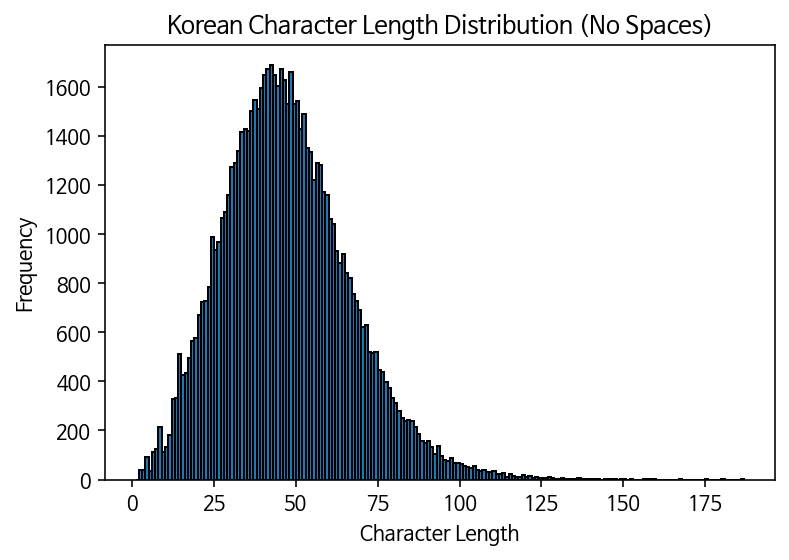

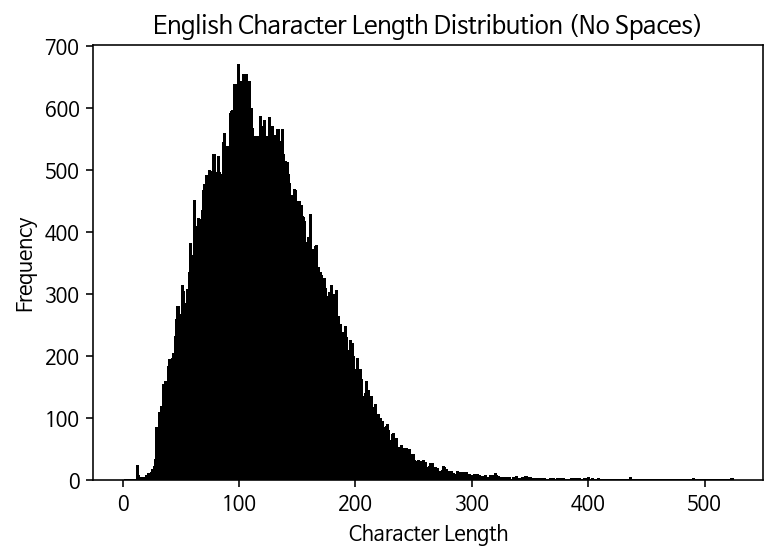

In [22]:
# 한국어 데이터 공백 제외한 글자 길이 분포
char_lengths_ko = [len(sentence.replace(" ", "")) for sentence in train_ko]

# 영어 데이터 공백 제외한 글자 길이 분포
char_lengths_en = [len(sentence.replace(" ", "")) for sentence in train_en]

plt.hist(char_lengths_ko, bins=range(1, max(char_lengths_ko) + 1), edgecolor='black')
plt.title("Korean Character Length Distribution (No Spaces)")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

plt.hist(char_lengths_en, bins=range(1, max(char_lengths_en) + 1), edgecolor='black')
plt.title("English Character Length Distribution (No Spaces)")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

### 생각해보면 한글이랑 영어를 같은 기준에 두고 글자 단위로 셀 순 없다. 
* 단어 기준으로 한글은 5글자를 넘어가는게 별로 없으나 영어는 무수히 많으니까

In [23]:
# 한국어(train_ko)와 영어(train_en) 데이터 필터링
# 공백 제외 단어 글자 길이 기준 
filtered_train_ko = []
filtered_train_en = []

for ko_sent, en_sent in zip(train_ko, train_en):
    if len(ko_sent.replace(" ", "")) <= 75 and len(en_sent.replace(" ", "")) <= 200:  # 공백 제외 글자 길이 기준
        filtered_train_ko.append(ko_sent)
        filtered_train_en.append(en_sent)

train_ko = filtered_train_ko
train_en = filtered_train_en

print(f"Filtered Korean Sentences: {len(train_ko)}")
print(f"Filtered English Sentences: {len(train_en)}")

Filtered Korean Sentences: 66703
Filtered English Sentences: 66703


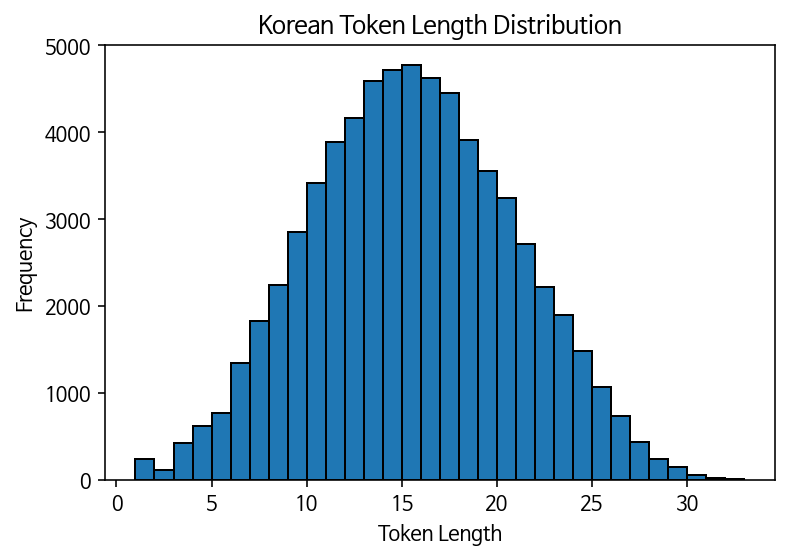

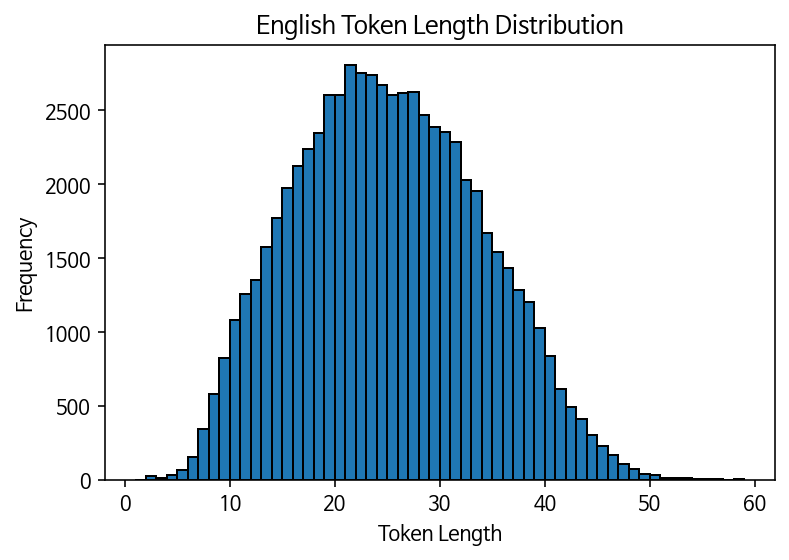

In [24]:
# 한국어 데이터 토큰 당 길이 분포
token_lengths_ko = [len(sentence.split()) for sentence in train_ko]

# 영어 데이터 토큰 당 길이 분포
token_lengths_en = [len(sentence.split()) for sentence in train_en]

# 한국어 데이터 토큰 길이 분포 히스토그램
plt.hist(token_lengths_ko, bins=range(1, max(token_lengths_ko) + 1), edgecolor='black')
plt.title("Korean Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

# 영어 데이터 토큰 길이 분포 히스토그램
plt.hist(token_lengths_en, bins=range(1, max(token_lengths_en) + 1), edgecolor='black')
plt.title("English Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

### 토큰화

In [25]:
# 공백으로 나눈 한국어
train_ko_words = " ".join(train_ko).split()

# 고유 단어 집합 생성
train_ko_unique_count = set(train_ko_words)

# 고유 단어 개수 출력
len(train_ko_unique_count)

164495

In [26]:
# 공백으로 나눈 영어
train_en_words = " ".join(train_en).split()

# 고유 단어 집합 생성
train_en_unique_count = set(train_en_words)

# 고유 단어 개수 출력
len(train_en_unique_count)

40539

In [27]:
from konlpy.tag import Mecab
from tqdm import tqdm

mecab = Mecab()

# 토큰화
kor_corpus = [" ".join(mecab.morphs(sentence)) for sentence in tqdm(train_ko, desc="Tokenizing train_ko")]

# 결과 확인 (예시로 처음 몇 개 출력)
print("Train KO Tokenized Example:", kor_corpus[:3])

Tokenizing train_ko: 100%|██████████| 66703/66703 [00:12<00:00, 5277.46it/s]

Train KO Tokenized Example: ['치와 와 애완견 인 피피 의 눈 은 주인 이 일 하 고 있 는 비좁 은 옷 가게 에서 낯선 사람 들 이 접근 하 면 사납 게 튀어나온다 .', '매도프 가 뉴욕 에서 억 달러 폰지 사기 혐의 로 체포 된 지 일 뒤 인 지난해 월 일 조각상 을 도난 당했 다 .', '국방부 부 장관 으로서 년 월 부터 지난 월 까지 곤 돌리 자 라이스 장관 을 보좌 했 다 .']


In [28]:
# 영어 데이터 공백 기준 토큰화
eng_corpus = [" ".join(sentence.split()) for sentence in tqdm(train_en, desc="Tokenizing train_en")]

# 결과 확인 (예시로 처음 몇 개 출력)
print("Train EN Tokenized Example:", eng_corpus[:3])

Tokenizing train_en: 100%|██████████| 66703/66703 [00:00<00:00, 483480.33it/s]

Train EN Tokenized Example: ['<start> taipei pipi s eyes bulge fiercely when strangers approach the chihuahua dog in the clothing store where her owner works . <end>', '<start> the statue was stolen december , eight days after madoff was arrested in new york on suspicion of operating a billion ponzi scheme . <end>', '<start> as deputy secretary of state , zoellick was chief aide to condoleezza rice between february and june last year . <end>']


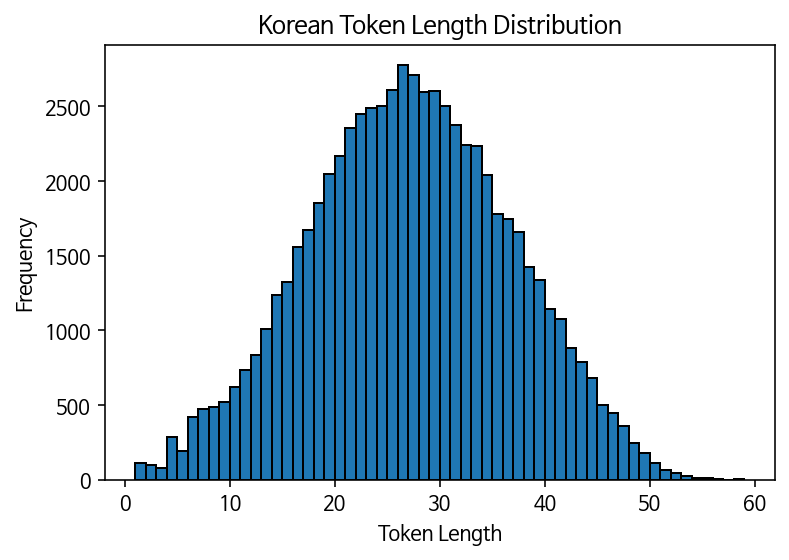

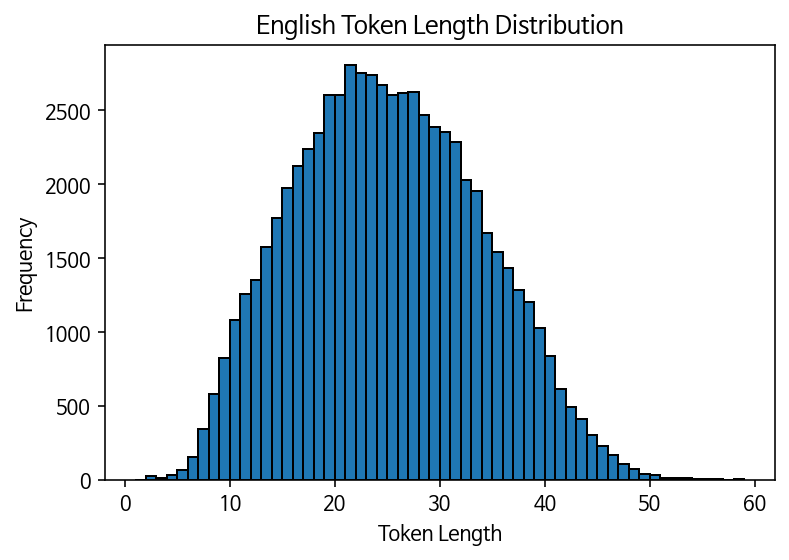

In [29]:
# 한국어 데이터 토큰 길이 분포
token_lengths_kor = [len(sentence.split()) for sentence in kor_corpus]

# 영어 데이터 토큰 길이 분포
token_lengths_eng = [len(sentence.split()) for sentence in eng_corpus]

# 한국어 데이터 토큰 길이 분포 히스토그램
plt.hist(token_lengths_kor, bins=range(1, max(token_lengths_kor) + 1), edgecolor='black')
plt.title("Korean Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

# 영어 데이터 토큰 길이 분포 히스토그램
plt.hist(token_lengths_eng, bins=range(1, max(token_lengths_eng) + 1), edgecolor='black')
plt.title("English Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

In [30]:
# 한국어(kor_corpus)와 영어(train_en) 데이터 필터링

filtered_kor_corpus = []
filtered_eng_corpus = []

for kor_sent, eng_sent in zip(kor_corpus, eng_corpus):
    if len(kor_sent.split()) <= 50 and len(eng_sent.split()) <= 50: # 결국 2차적인 절단을 하지 않으면 메모리 부족이 일어나기에 어쩔 수 없다. 
        filtered_kor_corpus.append(kor_sent)
        filtered_eng_corpus.append(eng_sent)

# 코퍼스 
kor_corpus = filtered_kor_corpus
eng_corpus = filtered_eng_corpus

print(f"Filtered Korean Corpus: {len(kor_corpus)} sentences")
print(f"Filtered English Corpus: {len(eng_corpus)} sentences")

Filtered Korean Corpus: 66517 sentences
Filtered English Corpus: 66517 sentences


In [31]:
# tokenize 함수 정의
def tokenize(corpus, num_words=None):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

# kor_corpus를 tensor와 tokenizer로 변환
enc_tensor, enc_tokenizer = tokenize(kor_corpus)  # 인코더
dec_tensor, dec_tokenizer = tokenize(eng_corpus)  # 디코더

print("Encoder Tensor :", enc_tensor[:3])
print("Decoder Tensor :", dec_tensor[:3])
print("Tokenizer Word Index Kor:", list(enc_tokenizer.word_index.items())[:10])  
print("Tokenizer Word Index Eng:", list(dec_tokenizer.word_index.items())[:10]) 

Encoder Tensor : [[13137    29  3504    24 14696     6   782     7  1417     3    26    11
     12    13     4 14697     7  1717  3553    16 13138    72    15     3
   1181    11    76 20251    44 26102     1     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [ 6409    14   251    16   188    88 26103  1874   160    21   266    43
     27    26   223    24   242    58    26  5248     5  3835   756     2
      1     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [  831   468   126  1249    36    58   170    63    58    67  3340  4972
     79   789   126     5 11869    10     2     1     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]
Decoder Tensor : [[    4  6260 20006    11  2223 

In [32]:
# validation X
enc_train = enc_tensor
dec_train = dec_tensor

print("Enc Train :", enc_train.shape)
print("Dec Train :", dec_train.shape)

Enc Train : (66517, 50)
Dec Train : (66517, 50)


In [34]:
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [35]:
# Bahdanau Attention Class
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [36]:
# Encoder Class
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.dropout = Dropout(0.2)
        self.gru = GRU(
            enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform'
        )

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        output, state = self.gru(x)
        return output, state

In [37]:
# Decoder Class
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.dropout = Dropout(0.2)
        self.gru = GRU(
            dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform'
        )
        self.fc = Dense(vocab_size)
        self.attention = BahdanauAttention(dec_units)

    def call(self, x, hidden, enc_out):
        x = self.embedding(x)
        x = self.dropout(x)
        context_vector, attn_weights = self.attention(hidden, enc_out)
        context_vector = tf.expand_dims(context_vector, 1)
        x = tf.concat([context_vector, x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attn_weights

In [38]:
# Teacher Forcing 비율
teacher_forcing_ratio = 0.8

# Loss Function
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

In [39]:
# 학습 단계 - Teacher Forcing
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out, enc_hidden = encoder(src)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_out)
            loss += loss_function(tgt[:, t], predictions)

            # Teacher Forcing 비율에 따라 디코더 입력 결정
            if np.random.rand() < teacher_forcing_ratio:
                dec_input = tf.expand_dims(tgt[:, t], 1)  # 실제 단어 
            else:
                predicted_id = tf.argmax(predictions, axis=1)  # 예측 단어 
                dec_input = tf.expand_dims(predicted_id, 1)

    batch_loss = loss / int(tgt.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [40]:
# Length Normalization & Top-k Sampling
def top_k_sampling(predictions, k=5):
    top_k_values, top_k_indices = tf.nn.top_k(predictions, k=k)
    top_k_probs = tf.nn.softmax(top_k_values).numpy()
    sampled_index = np.random.choice(top_k_indices.numpy(), p=top_k_probs)
    return sampled_index

def evaluate(sentence, encoder, decoder, enc_tok, dec_tok):
    inputs = enc_tok.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=enc_tensor.shape[-1], padding='post')
    enc_out, enc_hidden = encoder(inputs)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([dec_tok.word_index['<start>']], 0)

    result = ''
    length_penalty = 0.6  # Length Normalization 하이퍼파라미터

    for t in range(dec_tensor.shape[1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        predictions = predictions / ((5 + t + 1) ** length_penalty)  # Length Normalization 적용
        predicted_id = top_k_sampling(predictions[0], k=5)  # Top-k Sampling 적용
        result += dec_tok.index_word[predicted_id] + ' '

        if dec_tok.index_word[predicted_id] == '<end>':
            break
        dec_input = tf.expand_dims([predicted_id], 0)

    return result.strip()

In [42]:
# 학습 및 평가 루프
EPOCHS = 5
BATCH_SIZE = 64

# 데이터 준비
train_dataset = tf.data.Dataset.from_tensor_slices((enc_tensor, dec_tensor))
train_dataset = train_dataset.shuffle(buffer_size=len(enc_tensor)).batch(BATCH_SIZE, drop_remainder=True)

SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1
embedding_dim = 512
units = 1024

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [45]:
# 번역 함수
def translate(sentence, encoder, decoder, enc_tok, dec_tok):
    result = evaluate(sentence, encoder, decoder, enc_tok, dec_tok)
    print(f'Input: {sentence}')
    print(f'Predicted translation: {result}')

In [222]:
# 어텐션 시각화 함수
def plot_attention(input_sentence, translated_sentence, attention_weights, enc_tok, dec_tok):
    input_tokens = enc_tok.texts_to_tokens([input_sentence])[0]  # 입력 토큰
    translated_tokens = dec_tok.texts_to_tokens([translated_sentence])[0]  # 번역 토큰

    # 어텐션 가중치 배열로 변호나 
    attention_array = np.array(attention_weights)

    fig, ax = plt.subplots()
    cax = ax.matshow(attention_array, cmap='viridis')

    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(translated_tokens)))
    ax.set_xticklabels(input_tokens, rotation=90)
    ax.set_yticklabels(translated_tokens)

    plt.colorbar(cax)
    plt.show()

In [44]:
# 학습 진행
for epoch in range(EPOCHS):
    start_time = time.time()  # 시작 시간 기록
    total_loss = 0

    # tqdm
    with tqdm(train_dataset, desc=f"Epoch {epoch + 1}/{EPOCHS}", unit="batch") as pbar:
        for (batch, (src, tgt)) in enumerate(pbar):
            batch_loss = train_step(src, tgt, encoder, decoder, optimizer, dec_tokenizer)
            total_loss += batch_loss

            # tqdm 업데이트 - 현재 배치의 손실 
            pbar.set_postfix({"Batch Loss": batch_loss.numpy()})

    avg_loss = total_loss / (batch + 1)
    end_time = time.time()  # 종료 시간 기록

    elapsed_time = end_time - start_time  # 소요 시간 계산
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {avg_loss.numpy():.4f}, Time: {elapsed_time:.2f} seconds")

Epoch 1/5: 100%|██████████| 1039/1039 [14:02<00:00,  1.23batch/s, Batch Loss=2.74]


Epoch 1/5, Loss: 3.0212, Time: 842.76 seconds


Epoch 2/5: 100%|██████████| 1039/1039 [14:15<00:00,  1.21batch/s, Batch Loss=2.39]


Epoch 2/5, Loss: 2.6183, Time: 855.63 seconds


Epoch 3/5: 100%|██████████| 1039/1039 [14:16<00:00,  1.21batch/s, Batch Loss=2.3] 


Epoch 3/5, Loss: 2.3469, Time: 856.60 seconds


Epoch 4/5: 100%|██████████| 1039/1039 [14:16<00:00,  1.21batch/s, Batch Loss=2.18]


Epoch 4/5, Loss: 2.1204, Time: 856.11 seconds


Epoch 5/5: 100%|██████████| 1039/1039 [14:15<00:00,  1.21batch/s, Batch Loss=1.9] 

Epoch 5/5, Loss: 1.9046, Time: 855.41 seconds


In [47]:
translate("오바마는 미국의 대통령입니다.", encoder, decoder, enc_tokenizer, dec_tokenizer)
translate("시민들은 도시 속에 산다.", encoder, decoder, enc_tokenizer, dec_tokenizer)
translate("커피는 필요 없다.", encoder, decoder, enc_tokenizer, dec_tokenizer)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder, enc_tokenizer, dec_tokenizer)

Input: 오바마는 미국의 대통령입니다.
Predicted translation: i think it is going . <end>
Input: 시민들은 도시 속에 산다.
Predicted translation: and cities <end>
Input: 커피는 필요 없다.
Predicted translation: you know you don t know if we can t change need to make it is to the . , <end>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they were one person . points to . points and . <end>


In [48]:
# 6번부터 10번까지 추가 학습
for epoch in range(5, 10):  # Epoch 6~10
    start_time = time.time()  
    total_loss = 0

    with tqdm(train_dataset, desc=f"Epoch {epoch + 1}/10", unit="batch") as pbar:
        for (batch, (src, tgt)) in enumerate(pbar):
            batch_loss = train_step(src, tgt, encoder, decoder, optimizer, dec_tokenizer)
            total_loss += batch_loss

            pbar.set_postfix({"Batch Loss": batch_loss.numpy()})

    avg_loss = total_loss / (batch + 1)
    end_time = time.time() 

    elapsed_time = end_time - start_time  
    print(f"Epoch {epoch + 1}/10, Loss: {avg_loss.numpy():.4f}, Time: {elapsed_time:.2f} seconds")

Epoch 6/10: 100%|██████████| 1039/1039 [14:07<00:00,  1.23batch/s, Batch Loss=1.73]


Epoch 6/10, Loss: 1.6972, Time: 847.90 seconds


Epoch 7/10: 100%|██████████| 1039/1039 [14:13<00:00,  1.22batch/s, Batch Loss=1.71]


Epoch 7/10, Loss: 1.5053, Time: 853.89 seconds


Epoch 8/10: 100%|██████████| 1039/1039 [14:13<00:00,  1.22batch/s, Batch Loss=1.47]


Epoch 8/10, Loss: 1.3312, Time: 853.99 seconds


Epoch 9/10: 100%|██████████| 1039/1039 [14:12<00:00,  1.22batch/s, Batch Loss=1.27]


Epoch 9/10, Loss: 1.1761, Time: 852.89 seconds


Epoch 10/10: 100%|██████████| 1039/1039 [14:12<00:00,  1.22batch/s, Batch Loss=0.922]

Epoch 10/10, Loss: 1.0379, Time: 852.49 seconds


In [221]:
translate("오바마는 미국의 대통령입니다.", encoder, decoder, enc_tokenizer, dec_tokenizer)
translate("시민들은 도시 속에 산다.", encoder, decoder, enc_tokenizer, dec_tokenizer)
translate("커피는 필요 없다.", encoder, decoder, enc_tokenizer, dec_tokenizer)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder, enc_tokenizer, dec_tokenizer)

Input: 오바마는 미국의 대통령입니다.
Predicted translation: two hamburgers to be properly , the <end>
Input: 시민들은 도시 속에 산다.
Predicted translation: city <end>
Input: 커피는 필요 없다.
Predicted translation: better rights for this material to a . plan . need . survey <end>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people <end>


### 성능이 좋지 못하다

#### 문장이 어느 정도 길다면, 엄청 짧을 때보단 조금 괜찮은 것 같기도한데 사실 번역이라는 관점에선 더 안좋을 뿐이다. 단순하게 단어가 많아져서 비슷한 단어가 눈에 띄기에 그렇게 보이는 것 뿐.

* 아래 예시는 test 에서 가져온 것

#### train input, onput 길이를 적절하게 선별하고 적절한 기법들을 활용했기에 비슷한 길이로라도 나오는 것이지 이전 실험처럼 아예 번역 자체가 안되거나 반복만 주구장창 나오는 일이 빈번하다.
#### GRU의 장기 기억 문제가 맥락 자체를 가져가지 못하기에 번역으로는 볼 수 없겠다.

In [192]:
translate("이는 북한이 오랫동안 은폐해 온 핵 프로그램의 상징물을 파괴한 것이나 다름 없다 .", encoder, decoder, enc_tokenizer, dec_tokenizer)

Input: 이는 북한이 오랫동안 은폐해 온 핵 프로그램의 상징물을 파괴한 것이나 다름 없다 .
Predicted translation: we have no nuclear bombs have been going or if not been going on the nuclear device , . hello ? . be the position to this . our position , <end>


In [198]:
translate("오늘은 월가의 가장 힘든 날 중 하나였는데 , 개장 시간 동안 저점에서는 포인트나 지수가 떨어졌다 .", encoder, decoder, enc_tokenizer, dec_tokenizer)

Input: 오늘은 월가의 가장 힘든 날 중 하나였는데 , 개장 시간 동안 저점에서는 포인트나 지수가 떨어졌다 .
Predicted translation: among our most wanted me in this night in that followed most of all time within two days . the night <end>


In [214]:
translate("로버트 무가베 대통령과 그의 측근 명에 대한 미국 주도의 유엔 안보리 제재 결의안이 공개됐다 .", encoder, decoder, enc_tokenizer, dec_tokenizer)

Input: 로버트 무가베 대통령과 그의 측근 명에 대한 미국 주도의 유엔 안보리 제재 결의안이 공개됐다 .
Predicted translation: president robert gates will introduce his security council for president . <end>


In [220]:
translate("중국 정부가 최근 칭다오에 있는 베이징 올림픽 요트 경기장에 확산됐던 녹조를 완전히 제거했다고 관계자가 일 밝혔다 .", encoder, decoder, enc_tokenizer, dec_tokenizer)

Input: 중국 정부가 최근 칭다오에 있는 베이징 올림픽 요트 경기장에 확산됐던 녹조를 완전히 제거했다고 관계자가 일 밝혔다 .
Predicted translation: beijing s main railway company in the country is getting a big storm . china s olympic olympic games . it s the beijing on wednesday for chinese , . it s the games , with china . it will likely in this place in the summer . . in


In [191]:
test_ko

['이는 북한이 오랫동안 은폐해 온 핵 프로그램의 상징물을 파괴한 것이나 다름 없다 .',
 '낸시 펠로시 미 하원의장은 일 조지 w 부시 미 대통령은 총체적 실패자 라며 대통령에 대해 가장 신랄한 비판을 했다 .',
 '오늘은 월가의 가장 힘든 날 중 하나였는데 , 개장 시간 동안 저점에서는 포인트나 지수가 떨어졌다 .',
 '존은 베니스 거리에서 딸이 죽었을 때 입었던 빨간 우비를 입은 누군가의 흐릿한 모습을 보게 되는 환상을 경험하기 시작한다 .',
 '볼리비아 남부 안데스 산맥에서 농부들을 태운 트럭이 m 아래의 계곡으로 추락해 최소 명이 사망했다고 일 현지경찰이 밝혔다 .',
 '이러한 국가들을 이끌어가는 정권들에게는 , 안정이란 부와 권력 및 생존과 직결되는 것을 뜻하는 것이다 .',
 '로버트 무가베 대통령과 그의 측근 명에 대한 미국 주도의 유엔 안보리 제재 결의안이 공개됐다 .',
 '. 화씨온도에 를 빼서 기준을 맞춰준 다음 , 으로 나누고 으로 곱하면 섭씨온도가 된다 .',
 '검사는 그가 실종된 지 개월이 지난 년 그의 사망을 선고했었다 .',
 '안 위원장은 이들도 역시 한국인이며 , 인권 보호가 보장되어야 한다고 말했다 .',
 '호나우디뉴는 이곳에 와서 기쁘며 밀라노의 팬들에게 즐거움을 선사하고 싶다 고 강조했다 .',
 '인피니티 풀가 그 대표적인 예다 .',
 '콜롬비아 밀림에서 년 동안 억류됐던 베탕쿠르는 위장용 조끼 , 모자를 착용했으며 건강한 모습이었다 .',
 '매년 열리는 불꽃놀이가 올해로 회째를 맞이하면서 저녁 시 분부터 아메리칸 댄스 라는 제목의 화려한 행사가 준비되어 있다 .',
 '중국 정부가 최근 칭다오에 있는 베이징 올림픽 요트 경기장에 확산됐던 녹조를 완전히 제거했다고 관계자가 일 밝혔다 .',
 '미국 당국은 md 기지가 중동에서 발사되는 미사일로부터 유럽 대륙을 보호하기 위한 것이라고 강조했다 .',
 '잘생긴 기타리스트인 로니는 최근 몇 년 동안 건강해 보였다 .',
 '한국의 물가는 세계 에서 가장 비

In [225]:
translate("며칠간의 공백기 끝에 , 탈레반 무장 단체와 한국 정부 관계자는 남은 명의 한국인 인질들의 운명에 대한 논의를 재개하기로 했다 . 인질들은 전쟁으로 황폐화된 아프가니스탄에서 억류된 상태로 주째를 맞고 있다 . 증시의 일 연속 상승세는 포커의 포카드만큼이나 드문 일은 아니지만 , 증권거래원들은 오늘도 다우지수가 상승하면서 개장한 증시 때문에 흥분해 있습니다 .", encoder, decoder, enc_tokenizer, dec_tokenizer)

Input: 며칠간의 공백기 끝에 , 탈레반 무장 단체와 한국 정부 관계자는 남은 명의 한국인 인질들의 운명에 대한 논의를 재개하기로 했다 . 인질들은 전쟁으로 황폐화된 아프가니스탄에서 억류된 상태로 주째를 맞고 있다 . 증시의 일 연속 상승세는 포커의 포카드만큼이나 드문 일은 아니지만 , 증권거래원들은 오늘도 다우지수가 상승하면서 개장한 증시 때문에 흥분해 있습니다 .
Predicted translation: a third group drop its highest ever again , the lowest levels on the korean statistical office in a quarter gain on top korean troops are south japan . the korea herald , seoul s main attacks and its main stock market that is pulling south koreans who had the


#### 좀 더 돌려서 Loss가 더 떨어질때까지 진행하면, 조금쯤은 성능이 좋아지겠으나 GRU를 활용한 번역 한계가 너무 뚜렷하게 보이기에 큰 의미는 없을 것이다